In [16]:
!pip install nba_api
!pip install tqdm

In [567]:
from nba_api.stats.endpoints import commonallplayers,commonplayerinfo,playercareerstats,playerprofilev2
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time
import seaborn as sns


In [18]:
# ---- 1º Collecting information for building our dataset ----

In [19]:
# --- current season 2021/22 -> nba_current_players_list.csv
#504 players 

def get_and_save_players_list():

    '''
    This function return a csv -> nba_current_players_list.csv
    with information of the NBA players of the 
    season 2021-22 -only active players-

    commonallplayers: is the endpoint of the NBA API with the players
    of the season 2021-22. 
    You can see this information on:
    https://github.com/swar/nba_api/tree/master/nba_api
    '''
    active_players = commonallplayers.CommonAllPlayers(is_only_current_season=1, 
                                                       season="2021-22").get_data_frames()[0]
    active_players = active_players[(active_players["TEAM_ID"] != 0) & 
                                    (active_players["GAMES_PLAYED_FLAG"] != "N") & 
                                    (active_players["PERSON_ID"] != 1630597 )]
                                                         
    active_players = active_players[["PERSON_ID", "DISPLAY_FIRST_LAST","TEAM_NAME"]].rename(
        {'PERSON_ID':'PLAYER_ID','DISPLAY_FIRST_LAST':'PLAYER_NAME'}, axis=1 
    )
    active_players.to_csv("nba_current_players_list.csv")
    
    return active_players

current_players_list = get_and_save_players_list()



In [32]:
# create a list with all the ID of the active players on the
# season 2021-22 to obtain after more information
# about the same players

players_id = list(current_players_list["PLAYER_ID"])


In [21]:
#--- players personal information -> nba_players_personal_info.csv

def get_players_personal_information(current_players_list):
       
    '''
    This function return a DataFrame
    with personal information of the NBA players of the 
    season 2021-22 -only active players-

    commonplayerinfo: is the endpoint of the NBA API. 

    player_id : is a parameter of the Class CommonPlayerInfo of the
    endpoint commonplayerinfo. In this case 'player' are the active players
    of the season 2021-22

    You can see this information on:
    https://github.com/swar/nba_api/tree/master/nba_api

    This function have a time.sleep because making API calls 
    -to NBA API- can be complex and full of errors e.g "TimeOut"
    '''
    try:
        df_players = pd.DataFrame()
        for player in players_id:
            player_info = commonplayerinfo.CommonPlayerInfo(player_id=player).common_player_info.get_data_frame()
            player_info = player_info.rename(columns={"PERSON_ID":"PLAYER_ID"})
            player_info = player_info.drop(columns={"FIRST_NAME", "LAST_NAME","DISPLAY_LAST_COMMA_FIRST", 
                                                    "DISPLAY_FI_LAST", "PLAYER_SLUG", "SCHOOL",
                                                    "LAST_AFFILIATION","ROSTERSTATUS", 
                                                    "GAMES_PLAYED_CURRENT_SEASON_FLAG","JERSEY",
                                                    "TEAM_ABBREVIATION","TEAM_CODE","TEAM_CITY",
                                                    "PLAYERCODE","DLEAGUE_FLAG","NBA_FLAG","GAMES_PLAYED_FLAG",
                                                    "DRAFT_YEAR","DRAFT_ROUND","GREATEST_75_FLAG"})
            df_players = pd.concat([player_info, df_players])
            time.sleep(0.8)
    except Exception as excep:
        print(excep)   
    return df_players

players_personal_info = get_players_personal_information(current_players_list)
players_personal_info.to_csv("nba_players_personal_info.csv")


In [22]:
#--- players career stats -> nba_players_career_stats.csv

def get_players_career_stats(current_players_list):
 
    '''
    This function return a DataFrame
    with statistics of the NBA players of the 
    season 2021-22 -only active players-

    playercareerstats: is the endpoint of the NBA API

    player_id : is a parameter of the Class PlayerCareerStats of the
    endpoint playercareerstats. In this case 'player' are the active players
    of the season 2021-22

    per_mode36="PerGame": is a parameter of the 
    Class PlayerCareerStats bring back different
    statistics of the players per game

    You can see this information on:
    https://github.com/swar/nba_api/tree/master/nba_api

    This function have a time.sleep because making API calls 
    -to NBA API- can be complex and full of errors e.g "TimeOut"   
    '''
    
    try:
        df_stats = pd.DataFrame()
        for player in players_id:
            player_stats = playercareerstats.PlayerCareerStats(player_id=player, per_mode36='PerGame').career_totals_regular_season.get_data_frame()
            player_stats = player_stats.drop(columns={"LEAGUE_ID","Team_ID","GS","FGM","FGA","FG_PCT","FG3M",
                                                      "FG3A","FG3_PCT","FTM","FTA","FT_PCT","DREB",
                                                      "TOV","PF","Team_ID","OREB"})
            df_stats = pd.concat([player_stats, df_stats])
            time.sleep(0.8)
    except Exception as excep:
        print(excep)   
    return df_stats
    

In [23]:
players_career_stats = get_players_career_stats(current_players_list)
players_career_stats.to_csv("nba_players_career_stats.csv")


In [24]:
#---players next game -> nba_players_next_game.csv

from tqdm import tqdm

def get_players_next_game(current_players_list):
    
    '''
    This function return a DataFrame
    with the next games of NBA

    playerprofilev2: is the endpoint of the NBA API. 

    player_id : is a parameter of the Class PlayerProfileV2 of the
    endpoint playerprofilev2. In this case 'player' are the active players
    of the season 2021-22

    per_mode36="Totals": is a parameter of the 
    Class PlayerProfileV2 

    You can see this information on:
    https://github.com/swar/nba_api/tree/master/nba_api

    This function have a time.sleep because making API calls 
    -to NBA API- can be complex and full of errors e.g "TimeOut"   
    '''   
    
    try:
        df_nextGame = pd.DataFrame()
        for player in tqdm(players_id):
            next_game = playerprofilev2.PlayerProfileV2(player_id=player, per_mode36="Totals").next_game.get_data_frame()
            next_game["PLAYER_ID"] = player
            df_nextGame = pd.concat([next_game, df_nextGame])
            time.sleep(0.8)
    except Exception as excep:
        print(excep)   
    return df_nextGame  

    

In [25]:
players_next_game = get_players_next_game(current_players_list)
players_next_game.to_csv("nba_players_next_game.csv")

100%|█████████████████████████████████████████| 504/504 [16:52<00:00,  2.01s/it]


In [27]:
# --- salaries -> nba_players_salary.csv

def get_nba_players_salaries(csv_file_path): 
    
    '''
    This function return a DataFrame
    with the salaries of the NBA players

    You can see this information on:
    https://www.basketball-reference.com/contracts/players.html
    '''
        
    salaries = pd.DataFrame()
    for player in players_id:
        salaries = pd.read_excel("salariessinlimpiar.xlsx")
        salaries = salaries.rename(columns={"Player":"PLAYER_NAME"})
    prefijos = ["Jr.","Sr.","II","III","IV","V"]
    for pref in prefijos:
        salaries["PLAYER_NAME"] = salaries["PLAYER_NAME"].replace({pref:""}, regex=True).str.strip()
    return salaries

In [28]:
players_salaries = get_nba_players_salaries("contracts.csv")
players_salaries.to_csv("nba_players_salary.csv")

In [ ]:
# I need to see all the columns of the DF to clean it
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None

In [671]:
# I need to read each csv to do more agile the work

current_players_list = pd.read_csv("nba_current_players_list.csv")
current_players_list = current_players_list.drop(columns={"Unnamed: 0"})

players_personal_info = pd.read_csv("nba_players_personal_info.csv")
players_personal_info = players_personal_info.drop(columns={"Unnamed: 0"})

players_career_stats = pd.read_csv("nba_players_career_stats.csv")
players_career_stats  = players_career_stats.drop(columns={"Unnamed: 0"})

players_next_game = pd.read_csv("nba_players_next_game.csv")
players_next_game = players_next_game.drop(columns={"Unnamed: 0"})

players_salaries = pd.read_csv("nba_players_salary.csv")
players_salaries = players_salaries.drop(columns={"Unnamed: 0.1"})
players_salaries = players_salaries.drop(columns={"Unnamed: 0"})




In [672]:
# -- COMPLETE DF W/ ALL THE INFORMATION -> raw_nba_players_dataset.csv

def merge_dataframes(players_personal_info, players_career_stats, players_next_game, 
                     players_salaries
                    ):
       
    '''
    This function return a DataFrame
    with personal information, statistics, next games and
    salaries of the NBA players

    All information was collected 
    of the NBA API
    '''
    # -- MERGE 1: players_personal_info + players_career_stats
    DataSet1 = pd.merge(players_personal_info, players_career_stats, on="PLAYER_ID")
    DataSet1 = DataSet1.rename(columns={"DISPLAY_FIRST_LAST":"PLAYER_NAME"})
   
    # -- MERGE 2: DataFrame1 + players_salaries
    DataSet1 = pd.merge(DataSet1, players_salaries, how="left", on="PLAYER_NAME")
    
    # -- MERGE 3: DataFrame2 + players_next_game
    DataSet1 = pd.merge(DataSet1, players_next_game, how="left", on="PLAYER_ID") 
    
    
    DataSet1 = DataSet1.reindex(columns= ["PLAYER_ID", "PLAYER_NAME", "TEAM_NAME",
                                          "POSITION","HEIGHT","WEIGHT","COUNTRY",
                                          "BIRTHDATE", "DRAFT_NUMBER","GP","MIN","PTS",
                                          "REB","AST","STL", "BLK","2021-22",
                                          "GAME_DATE","SEASON_EXP"
                                         ])
    DataSet1 = DataSet1.rename(columns={"2021-22":"SALARY_DOLLARS",
                                        "GAME_DATE":"NEXT_GAME_DATE",
                                        "DRAFT_NUMBER":"DRAFT_POSITION"
                                       })
    return DataSet1
   

In [673]:
raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, 
                                       players_next_game, players_salaries)
raw_players_dataset.to_csv("raw_nba_players_dataset.csv", index=False)

In [674]:
raw_players_dataset = pd.read_csv("raw_nba_players_dataset.csv")

In [675]:
# --- 2º Data Cleaning and Preprocessing -----

In [676]:
# Complete in this cell: copy the dataset and drop NaNs in team or salary

def copy_and_delete_nan(raw_players_datase):
    
    '''
    This function create a copy of the original dataset
    with the complete information about players of
    the NBA and delete the players that they don`t have
    salary or team.
    '''

    working_df = raw_players_dataset.copy()
    working_df = working_df.dropna(subset=["SALARY_DOLLARS"])
    working_df = working_df.dropna(subset=["TEAM_NAME"])
    
    return working_df

working_df = copy_and_delete_nan(raw_players_dataset)

In [677]:
# Cast Salary, Birthday and Game Date columns to its corresponding type (int, datetime)

def cast_columns(working_df):
    '''
    This function set up the correct type of 
    data about Salaries, Birthdate and Date of
    the next games.
    '''
    working_df['SALARY_DOLLARS'] = working_df['SALARY_DOLLARS'].astype('int64')
    working_df["BIRTHDATE"]= pd.to_datetime(working_df["BIRTHDATE"],format="%Y-%m-%d")
    working_df["NEXT_GAME_DATE"] = working_df["NEXT_GAME_DATE"].astype('datetime64')
    
    return working_df

cast_columns(working_df)

,PLAYER_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,DRAFT_POSITION,GP,MIN,PTS,REB,AST,STL,BLK,SALARY_DOLLARS,NEXT_GAME_DATE,SEASON_EXP
0,1627826,Ivica Zubac,Clippers,Center,7-0,240,Croatia,1997-03-18,32,360,19.0,8.3,6.5,1.1,0.3,0.8,7518518,NaT,5
1,1630209,Omer Yurtseven,Heat,Center,6-11,275,Turkey,1998-06-19,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,2022-04-26,0
2,1629027,Trae Young,Hawks,Guard,6-1,164,USA,1998-09-19,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,2022-04-26,3
3,201152,Thaddeus Young,Raptors,Forward,6-8,235,USA,1988-06-21,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,2022-04-28,14
7,1626153,Delon Wright,Hawks,Guard,6-5,185,USA,1992-04-26,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,2022-04-26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,200746,LaMarcus Aldridge,Nets,Center-Forward,6-11,250,USA,1985-07-19,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,2022-04-27,15
499,1630583,Santi Aldama,Grizzlies,Forward-Center,6-11,215,Spain,2001-01-10,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,2022-04-26,0
500,1628389,Bam Adebayo,Heat,Center-Forward,6-9,255,USA,1997-07-18,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,2022-04-26,4
501,203500,Steven Adams,Grizzlies,Center,6-11,265,New Zealand,1993-07-20,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,2022-04-26,8


In [678]:
# function to apply a height_cm

def height(num): 

    height = num.split("-")


    num_izq = int(height[0])* 30.48
    num_der = int(height[1])* 2.54
    total = int(num_izq + num_der)

    return total

In [679]:
# Create a function that converts the height column from 
# height in feet and inches to centimeters


def convert_height_column(working_df):
    '''
    This function calculate the height from ft. 
    and in.to cm. 
    
    1 ft. = 30,48 cm
    1 in. = 2,54 cm
    '''
    working_df["HEIGHT"] = working_df["HEIGHT"].apply(height)
    return working_df

convert_height_column(working_df)

,PLAYER_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,DRAFT_POSITION,GP,MIN,PTS,REB,AST,STL,BLK,SALARY_DOLLARS,NEXT_GAME_DATE,SEASON_EXP
0,1627826,Ivica Zubac,Clippers,Center,213,240,Croatia,1997-03-18,32,360,19.0,8.3,6.5,1.1,0.3,0.8,7518518,NaT,5
1,1630209,Omer Yurtseven,Heat,Center,210,275,Turkey,1998-06-19,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,2022-04-26,0
2,1629027,Trae Young,Hawks,Guard,185,164,USA,1998-09-19,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,2022-04-26,3
3,201152,Thaddeus Young,Raptors,Forward,203,235,USA,1988-06-21,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,2022-04-28,14
7,1626153,Delon Wright,Hawks,Guard,195,185,USA,1992-04-26,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,2022-04-26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,200746,LaMarcus Aldridge,Nets,Center-Forward,210,250,USA,1985-07-19,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,2022-04-27,15
499,1630583,Santi Aldama,Grizzlies,Forward-Center,210,215,Spain,2001-01-10,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,2022-04-26,0
500,1628389,Bam Adebayo,Heat,Center-Forward,205,255,USA,1997-07-18,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,2022-04-26,4
501,203500,Steven Adams,Grizzlies,Center,210,265,New Zealand,1993-07-20,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,2022-04-26,8


In [680]:
# Create a function that converts the weight column from pounds to kilograms

def convert_weight_column(working_df):
    '''
    This function convert the weight in pounds
    from weight in kilograms.
    
    1 pound = 0,453592 kgs.
    '''
     
    working_df["WEIGHT"] = round(working_df["WEIGHT"]*0.453592, 2).astype(float)
    
    return working_df
    
    

convert_weight_column(working_df)

,PLAYER_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,DRAFT_POSITION,GP,MIN,PTS,REB,AST,STL,BLK,SALARY_DOLLARS,NEXT_GAME_DATE,SEASON_EXP
0,1627826,Ivica Zubac,Clippers,Center,213,108.86,Croatia,1997-03-18,32,360,19.0,8.3,6.5,1.1,0.3,0.8,7518518,NaT,5
1,1630209,Omer Yurtseven,Heat,Center,210,124.74,Turkey,1998-06-19,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,2022-04-26,0
2,1629027,Trae Young,Hawks,Guard,185,74.39,USA,1998-09-19,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,2022-04-26,3
3,201152,Thaddeus Young,Raptors,Forward,203,106.59,USA,1988-06-21,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,2022-04-28,14
7,1626153,Delon Wright,Hawks,Guard,195,83.91,USA,1992-04-26,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,2022-04-26,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,200746,LaMarcus Aldridge,Nets,Center-Forward,210,113.40,USA,1985-07-19,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,2022-04-27,15
499,1630583,Santi Aldama,Grizzlies,Forward-Center,210,97.52,Spain,2001-01-10,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,2022-04-26,0
500,1628389,Bam Adebayo,Heat,Center-Forward,205,115.67,USA,1997-07-18,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,2022-04-26,4
501,203500,Steven Adams,Grizzlies,Center,210,120.20,New Zealand,1993-07-20,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,2022-04-26,8


In [681]:
# Create column AGE

working_df["AGE"] = 0


In [682]:
# Create this function to do function add_age_column

def birthdate(date):
    birthdate = working_df["BIRTHDATE"].iloc[0]
    today = datetime.today()
    age = relativedelta(today, birthdate)

    years = age.years
    months = age.months
    days = age.days

    player_age = (f"{years} years, {months} months, {days} days")
    return player_age




In [683]:
# Create a function that calculates the age in (years, months, days) and saves 
# it in a new string column, example: "22 years, 5 months, 25 days"

def add_age_column(working_df): 
    '''
    This function calculate the age
    of the players in years, months
    and days
    '''
      
    working_df["AGE"] = working_df["AGE"].apply(birthdate) 
    
    return working_df

add_age_column(working_df)


,PLAYER_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,DRAFT_POSITION,GP,MIN,PTS,REB,AST,STL,BLK,SALARY_DOLLARS,NEXT_GAME_DATE,SEASON_EXP,AGE
0,1627826,Ivica Zubac,Clippers,Center,213,108.86,Croatia,1997-03-18,32,360,19.0,8.3,6.5,1.1,0.3,0.8,7518518,NaT,5,"25 years, 1 months, 10 days"
1,1630209,Omer Yurtseven,Heat,Center,210,124.74,Turkey,1998-06-19,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,2022-04-26,0,"25 years, 1 months, 10 days"
2,1629027,Trae Young,Hawks,Guard,185,74.39,USA,1998-09-19,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,2022-04-26,3,"25 years, 1 months, 10 days"
3,201152,Thaddeus Young,Raptors,Forward,203,106.59,USA,1988-06-21,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,2022-04-28,14,"25 years, 1 months, 10 days"
7,1626153,Delon Wright,Hawks,Guard,195,83.91,USA,1992-04-26,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,2022-04-26,6,"25 years, 1 months, 10 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,200746,LaMarcus Aldridge,Nets,Center-Forward,210,113.40,USA,1985-07-19,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,2022-04-27,15,"25 years, 1 months, 10 days"
499,1630583,Santi Aldama,Grizzlies,Forward-Center,210,97.52,Spain,2001-01-10,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,2022-04-26,0,"25 years, 1 months, 10 days"
500,1628389,Bam Adebayo,Heat,Center-Forward,205,115.67,USA,1997-07-18,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,2022-04-26,4,"25 years, 1 months, 10 days"
501,203500,Steven Adams,Grizzlies,Center,210,120.20,New Zealand,1993-07-20,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,2022-04-26,8,"25 years, 1 months, 10 days"


In [684]:
# Create a function that takes care of the disambiguation of the "POSITION" column. 
# Should replace all positions that are mixed with the first one listed.

def update_position(working_df):
    
    '''
    This function solve the problem of the 
    disambigution of the player's positions and
    return only the first position on the data
    for each player
    '''
    
    position = working_df["POSITION"].str.split("-", n=1, expand=True)
    working_df["POSITION"] = position[0]
    return working_df
    
    
update_position(working_df)   

,PLAYER_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,DRAFT_POSITION,GP,MIN,PTS,REB,AST,STL,BLK,SALARY_DOLLARS,NEXT_GAME_DATE,SEASON_EXP,AGE
0,1627826,Ivica Zubac,Clippers,Center,213,108.86,Croatia,1997-03-18,32,360,19.0,8.3,6.5,1.1,0.3,0.8,7518518,NaT,5,"25 years, 1 months, 10 days"
1,1630209,Omer Yurtseven,Heat,Center,210,124.74,Turkey,1998-06-19,Undrafted,56,12.6,5.3,5.3,0.9,0.3,0.4,1489065,2022-04-26,0,"25 years, 1 months, 10 days"
2,1629027,Trae Young,Hawks,Guard,185,74.39,USA,1998-09-19,5,280,33.6,25.3,3.9,9.1,0.9,0.2,8326471,2022-04-26,3,"25 years, 1 months, 10 days"
3,201152,Thaddeus Young,Raptors,Forward,203,106.59,USA,1988-06-21,12,1085,29.3,12.8,5.8,1.8,1.4,0.4,14190000,2022-04-28,14,"25 years, 1 months, 10 days"
7,1626153,Delon Wright,Hawks,Guard,195,83.91,USA,1992-04-26,20,411,20.9,7.2,3.2,3.0,1.2,0.4,8526316,2022-04-26,6,"25 years, 1 months, 10 days"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,200746,LaMarcus Aldridge,Nets,Center,210,113.40,USA,1985-07-19,2,1076,33.7,19.1,8.1,1.9,0.7,1.1,2641691,2022-04-27,15,"25 years, 1 months, 10 days"
499,1630583,Santi Aldama,Grizzlies,Forward,210,97.52,Spain,2001-01-10,30,32,11.2,4.1,2.7,0.7,0.2,0.3,1994520,2022-04-26,0,"25 years, 1 months, 10 days"
500,1628389,Bam Adebayo,Heat,Center,205,115.67,USA,1997-07-18,14,343,28.2,13.5,8.3,3.5,1.0,0.9,28103550,2022-04-26,4,"25 years, 1 months, 10 days"
501,203500,Steven Adams,Grizzlies,Center,210,120.20,New Zealand,1993-07-20,12,664,26.8,9.3,8.0,1.5,0.9,0.9,17073171,2022-04-26,8,"25 years, 1 months, 10 days"


In [685]:
working_df = working_df.astype({"PLAYER_NAME":str, "TEAM_NAME":str, "POSITION":str, 
                                "COUNTRY":str, "AGE":str, "HEIGHT":int})
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 502
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PLAYER_ID       393 non-null    int64         
 1   PLAYER_NAME     393 non-null    object        
 2   TEAM_NAME       393 non-null    object        
 3   POSITION        393 non-null    object        
 4   HEIGHT          393 non-null    int64         
 5   WEIGHT          393 non-null    float64       
 6   COUNTRY         393 non-null    object        
 7   BIRTHDATE       393 non-null    datetime64[ns]
 8   DRAFT_POSITION  389 non-null    object        
 9   GP              393 non-null    int64         
 10  MIN             393 non-null    float64       
 11  PTS             393 non-null    float64       
 12  REB             393 non-null    float64       
 13  AST             393 non-null    float64       
 14  STL             393 non-null    float64       
 15  BLK   

In [687]:
# Review that the working dataset has all requested columns with its 
# corresponding datatypes and save it as a csv with 
# name "nba_players_processed_dataset.csv"

working_df.to_csv("nba_players_processed_dataset.csv")


In [688]:
# --- 3º General Metrics ----

In [689]:
# Total number of players

working_df.info()

#393 PLAYERS


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 502
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   PLAYER_ID       393 non-null    int64         
 1   PLAYER_NAME     393 non-null    object        
 2   TEAM_NAME       393 non-null    object        
 3   POSITION        393 non-null    object        
 4   HEIGHT          393 non-null    int64         
 5   WEIGHT          393 non-null    float64       
 6   COUNTRY         393 non-null    object        
 7   BIRTHDATE       393 non-null    datetime64[ns]
 8   DRAFT_POSITION  389 non-null    object        
 9   GP              393 non-null    int64         
 10  MIN             393 non-null    float64       
 11  PTS             393 non-null    float64       
 12  REB             393 non-null    float64       
 13  AST             393 non-null    float64       
 14  STL             393 non-null    float64       
 15  BLK   

In [692]:
# Number of USA born players #307

usa = working_df["COUNTRY"] == "USA"
print (usa[usa])


2      True
3      True
7      True
9      True
10     True
       ... 
494    True
495    True
496    True
498    True
500    True
Name: COUNTRY, Length: 307, dtype: bool


In [693]:
# Number of foreign players # 86

foreign = working_df["COUNTRY"] != "USA"
print(foreign[foreign])

0      True
1      True
23     True
33     True
41     True
       ... 
492    True
497    True
499    True
501    True
502    True
Name: COUNTRY, Length: 86, dtype: bool


In [694]:
# Number of players per position

print("Number of players per position\n")

position_center = working_df["POSITION"] == "Center"
position_center = (position_center.sum())
print(f"{position_center} CENTER\n")

position_guard = working_df["POSITION"] == "Guard"
position_guard = (position_guard.sum())
print(f"{position_center} GUARD\n")

position_forward = working_df["POSITION"] == "Forward"
position_forward = (position_forward.sum())
print(f"{position_forward} GUARD\n")


Number of players per position

50 CENTER

50 GUARD

156 GUARD



In [695]:
# Number of players per team

teams = working_df.groupby(["TEAM_NAME"]).count()["PLAYER_ID"]
teams

TEAM_NAME
76ers            15
Bucks            13
Bulls            12
Cavaliers        14
Celtics          14
Clippers         12
Grizzlies        15
Hawks            12
Heat             13
Hornets          14
Jazz             13
Kings            14
Knicks           14
Lakers           15
Magic            14
Mavericks        11
Nets             14
Nuggets          11
Pacers           14
Pelicans         11
Pistons          13
Raptors          13
Rockets          11
Spurs            13
Suns             13
Thunder          13
Timberwolves     14
Trail Blazers    13
Warriors         13
Wizards          12
Name: PLAYER_ID, dtype: int64

In [696]:
# Number of rookies (first year players)

rookies = working_df["SEASON_EXP"] <= 1
print(f"Number of rookies: {(rookies[rookies]).count()}")



Number of rookies: 106


In [697]:
# --- 3º Players Descriptions ----

In [698]:
# Average player age (in years)


def age_average(date):
    birthdate = working_df["BIRTHDATE"].iloc[0]
    today = datetime.today()
    age = relativedelta(today, birthdate)

    years = age.years
    

    player_age = years
    return player_age

average_age = working_df["AGE"].apply(age_average)
print(f"Average player age: {average_age.mean()}")


Average player age: 25.0


In [699]:
# Youngest player age (years and days)

min_age = working_df["BIRTHDATE"].min()
min_age


Timestamp('1980-06-09 00:00:00')

In [700]:
# Oldest player age (years and days)

max_age = working_df["BIRTHDATE"].max()
max_age



Timestamp('2002-12-24 00:00:00')

In [701]:
# Min and Max players height

min_height = working_df["HEIGHT"].min()
max_height = working_df["HEIGHT"].max()


print(f"The max players height is: {max_height} cm. and the min {min_height} cm.")

The max players height is: 218 cm. and the min 175 cm.


In [702]:
# Average height of players per position

average_height = working_df.groupby(["POSITION"]).mean()["HEIGHT"]
average_height



POSITION
Center     210.280000
Forward    202.333333
Guard      191.860963
Name: HEIGHT, dtype: float64

In [703]:
# --- 3º Contracts ----

In [704]:
# Min and Max salary of all players

salary_min = working_df["SALARY_DOLLARS"].min()
salary_max = working_df["SALARY_DOLLARS"].max()

print(f"The salary min is: {salary_min} and the salary max is: {salary_max}")


The salary min is: 5318 and the salary max is: 45780966


In [705]:
# Mean and Median salary of all players

mean_salary = round(working_df["SALARY_DOLLARS"].mean())
median_salary = round(working_df["SALARY_DOLLARS"].median())

print(f"The mean salary is: {mean_salary} and the median salary is: {median_salary}")

The mean salary is: 8678312 and the median salary is: 4215120


In [706]:
# Plot the relationship between scoring (points per game) and 
# salary of all players, the players positions should also be visible.

<AxesSubplot:xlabel='PTS', ylabel='SALARY_DOLLARS'>

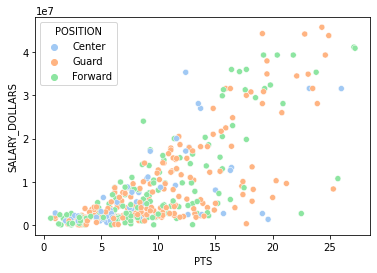

In [707]:
sns.scatterplot(data=working_df, x="PTS", y="SALARY_DOLLARS", hue="POSITION", palette= "pastel")

In [708]:
# Now plot assists-vs-salary and rebounding-vs-salary

<AxesSubplot:xlabel='AST', ylabel='SALARY_DOLLARS'>

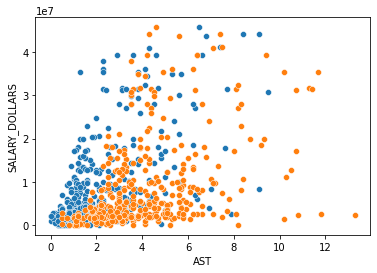

In [709]:
sns.scatterplot(x="AST", y= "SALARY_DOLLARS", data=working_df) # blue
sns.scatterplot(x="REB", y= "SALARY_DOLLARS", data=working_df) # orange

In [711]:
# points, assists and rebounding vs salary  + 4 years exp

players_exp = working_df[working_df["SEASON_EXP"] >= 4]
assist = players_exp["AST"]
points = players_exp["PTS"]
rebounding = players_exp["REB"]
salary = (players_exp["SALARY_DOLLARS"]/1000000)


<AxesSubplot:xlabel='AST', ylabel='SALARY_DOLLARS'>

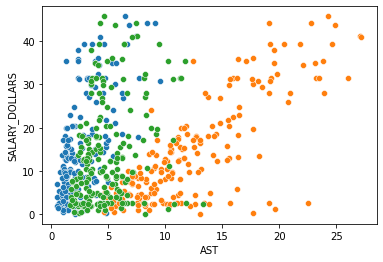

In [712]:
sns.scatterplot(x=assist, y= salary, data=players_exp) # blue
sns.scatterplot(x=points, y= salary, data=players_exp) # orange
sns.scatterplot(x=rebounding, y= salary, data=players_exp) # green

In [713]:
# Plot the scoring average grouped by position, we want to be able to see median, quartiles, etc

In [714]:
pts_mean = working_df.groupby(["POSITION"]).mean()["PTS"]
pts_mean


POSITION
Center      9.376000
Forward     9.716667
Guard      10.509091
Name: PTS, dtype: float64

<AxesSubplot:ylabel='PTS'>

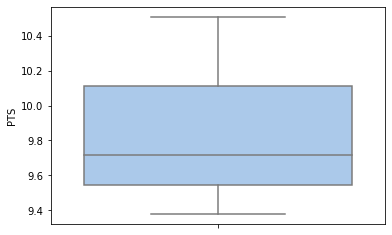

In [715]:
sns.boxplot(data=working_df, y=pts_mean, palette="pastel")

In [716]:
 # Plot the Height distribution of all players

<AxesSubplot:xlabel='HEIGHT', ylabel='count'>

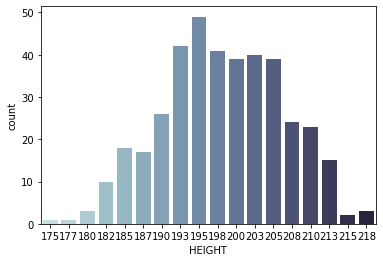

In [717]:
sns.countplot(data=working_df, x="HEIGHT", palette="ch:start=.2,rot=-.3")